In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelBinarizer


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:
# Core
import os, shutil, random, csv, math
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Tuple

# Numeric
import numpy as np

# Torch / CV
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

# Utils
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==== DATA CONFIG ====
# Your original dataset where each class is a subfolder:
SRC_DIR = "/kaggle/input/plantvillage-dataset/color"   # <-- change if needed

# Destination for the balanced copy (non-destructive)
DST_DIR = "/kaggle/working/plantvillage-balanced"

# How many samples per class to target
N_PER_CLASS = 350

# Sampling mode: "exact" | "undersample" | "oversample"
SAMPLING_MODE = "exact"

# Split ratios for the balanced copy
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.2
TEST_RATIO  = 0.1
assert math.isclose(TRAIN_RATIO + VAL_RATIO + TEST_RATIO, 1.0, rel_tol=1e-6)

# Image/loader params
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

# Training params
EPOCHS = 50
PATIENCE = 5
LR = 1e-4

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Image extensions to include
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"}

os.makedirs(DST_DIR, exist_ok=True)
print("Configured. Device:", device)


Configured. Device: cuda


In [5]:
def list_images_by_class(src_dir: str) -> Dict[str, List[Path]]:
    src = Path(src_dir)
    if not src.exists():
        raise FileNotFoundError(f"Source directory not found: {src_dir}")

    files_by_class = {}
    for p in sorted(src.iterdir()):
        if p.is_dir():
            cls = p.name
            imgs = [f for f in p.iterdir() if f.is_file() and f.suffix.lower() in IMG_EXTS]
            if imgs:
                files_by_class[cls] = sorted(imgs)
    if not files_by_class:
        raise RuntimeError(f"No class folders with images found under: {src_dir}")
    return files_by_class

files_by_class = list_images_by_class(SRC_DIR)
class_names = sorted(files_by_class.keys())
print(f"Found {len(class_names)} classes.")
for c in class_names:
    print(f"{c}: {len(files_by_class[c])} images")


Found 38 classes.
Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mil

In [6]:
def sample_for_class(paths: List[Path], n: int, mode: str) -> List[Path]:
    k = len(paths)
    if mode == "undersample":
        return paths.copy() if k <= n else random.sample(paths, n)

    if mode == "oversample":
        if k >= n:
            return random.sample(paths, n)
        extra = np.random.choice(paths, size=(n - k), replace=True).tolist()
        return paths.copy() + extra

    # mode == "exact"
    if k == n:
        return paths.copy()
    if k > n:
        return random.sample(paths, n)
    extra = np.random.choice(paths, size=(n - k), replace=True).tolist()
    return paths.copy() + extra

plan = {c: sample_for_class(files_by_class[c], N_PER_CLASS, SAMPLING_MODE)
        for c in class_names}

for c in class_names[:10]:
    print(c, "->", len(plan[c]), "files")


Apple___Apple_scab -> 350 files
Apple___Black_rot -> 350 files
Apple___Cedar_apple_rust -> 350 files
Apple___healthy -> 350 files
Blueberry___healthy -> 350 files
Cherry_(including_sour)___Powdery_mildew -> 350 files
Cherry_(including_sour)___healthy -> 350 files
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot -> 350 files
Corn_(maize)___Common_rust_ -> 350 files
Corn_(maize)___Northern_Leaf_Blight -> 350 files


In [7]:
def safe_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst)

manifest_path = Path(DST_DIR) / "manifest.csv"
with open(manifest_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["class", "src_path", "dst_path", "filename"])
    for cls in class_names:
        seen_counts = {}
        for src_path in plan[cls]:
            count = seen_counts.get(src_path, 0)
            suffix = f"__dup{count}" if count > 0 else ""
            seen_counts[src_path] = count + 1

            new_name = f"{src_path.stem}{suffix}{src_path.suffix}"
            dst_path = Path(DST_DIR) / cls / new_name
            safe_copy(src_path, dst_path)
            writer.writerow([cls, str(src_path), str(dst_path), new_name])

print(f"Balanced dataset written to: {DST_DIR}")
print(f"Manifest: {manifest_path}")


Balanced dataset written to: /kaggle/working/plantvillage-balanced
Manifest: /kaggle/working/plantvillage-balanced/manifest.csv


In [8]:
def count_images_by_class(root: str) -> Dict[str, int]:
    counts = {}
    root_p = Path(root)
    for cls_dir in sorted(root_p.iterdir()):
        if cls_dir.is_dir():
            n = len([f for f in cls_dir.iterdir() if f.is_file() and f.suffix.lower() in IMG_EXTS])
            counts[cls_dir.name] = n
    return counts

balanced_counts = count_images_by_class(DST_DIR)
print("Balanced counts per class:")
for c in class_names:
    print(f"{c}: {balanced_counts.get(c, 0)}")
print("\nTotal images:", sum(balanced_counts.values()))


Balanced counts per class:
Apple___Apple_scab: 350
Apple___Black_rot: 350
Apple___Cedar_apple_rust: 350
Apple___healthy: 350
Blueberry___healthy: 350
Cherry_(including_sour)___Powdery_mildew: 350
Cherry_(including_sour)___healthy: 350
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 350
Corn_(maize)___Common_rust_: 350
Corn_(maize)___Northern_Leaf_Blight: 350
Corn_(maize)___healthy: 350
Grape___Black_rot: 350
Grape___Esca_(Black_Measles): 350
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 350
Grape___healthy: 350
Orange___Haunglongbing_(Citrus_greening): 350
Peach___Bacterial_spot: 350
Peach___healthy: 350
Pepper,_bell___Bacterial_spot: 350
Pepper,_bell___healthy: 350
Potato___Early_blight: 350
Potato___Late_blight: 350
Potato___healthy: 350
Raspberry___healthy: 350
Soybean___healthy: 350
Squash___Powdery_mildew: 350
Strawberry___Leaf_scorch: 350
Strawberry___healthy: 350
Tomato___Bacterial_spot: 350
Tomato___Early_blight: 350
Tomato___Late_blight: 350
Tomato___Leaf_Mold: 350
Tomato___

In [9]:
from sklearn.model_selection import train_test_split

def stratified_split(root_dir: str):
    root = Path(root_dir)
    per_class_paths = {cls: sorted((root / cls).glob("*")) for cls in class_names}

    split_map = {"train": [], "val": [], "test": []}
    for cls, paths in per_class_paths.items():
        labels = [cls] * len(paths)
        X_train, X_tmp, y_train, y_tmp = train_test_split(
            paths, labels, test_size=(1 - TRAIN_RATIO), stratify=labels, random_state=SEED
        )
        rel = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
        X_val, X_test, _, _ = train_test_split(
            X_tmp, y_tmp, test_size=rel, stratify=y_tmp, random_state=SEED
        )
        split_map["train"].extend(X_train)
        split_map["val"].extend(X_val)
        split_map["test"].extend(X_test)
    return split_map

splits = stratified_split(DST_DIR)

for split in ["train", "val", "test"]:
    for p in splits[split]:
        cls = p.parent.name
        out = Path(DST_DIR) / split / cls / p.name
        out.parent.mkdir(parents=True, exist_ok=True)
        if not out.exists():
            shutil.copy2(p, out)

print("Created stratified splits under:")
print(f"- {Path(DST_DIR) / 'train'}")
print(f"- {Path(DST_DIR) / 'val'}")
print(f"- {Path(DST_DIR) / 'test'}")


Created stratified splits under:
- /kaggle/working/plantvillage-balanced/train
- /kaggle/working/plantvillage-balanced/val
- /kaggle/working/plantvillage-balanced/test


In [10]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dir = os.path.join(DST_DIR, "train")
val_dir   = os.path.join(DST_DIR, "val")
test_dir  = os.path.join(DST_DIR, "test")

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=test_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Classes:", train_ds.classes)
print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [11]:
# === Cell 8 — EarlyStopping + training helpers (handles GoogLeNet aux outputs) ===

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Stops training if validation loss doesn't improve after `patience` epochs.
        min_delta: minimum improvement to reset patience.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss: float):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def _is_googlenet_outputs(outputs):
    """
    Returns True if outputs look like torchvision GoogLeNet namedtuple
    with .logits (and possibly .aux_logits1 / .aux_logits2)
    """
    return hasattr(outputs, "logits")


def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    Train for one epoch. If the model is GoogLeNet with aux heads enabled,
    include auxiliary losses (weighted) during training.
    """
    model.train()
    loss_sum, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        if _is_googlenet_outputs(outputs):
            # Main logits
            main_logits = outputs.logits
            loss = criterion(main_logits, labels)
            # Add aux losses if present
            if hasattr(outputs, "aux_logits1") and outputs.aux_logits1 is not None:
                loss = loss + 0.3 * criterion(outputs.aux_logits1, labels)
            if hasattr(outputs, "aux_logits2") and outputs.aux_logits2 is not None:
                loss = loss + 0.3 * criterion(outputs.aux_logits2, labels)
            preds = main_logits.argmax(1)
        else:
            # Standard case (VGG16, ResNet50, MobileNetV2, etc.)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * images.size(0)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    epoch_loss = loss_sum / max(1, total)
    epoch_acc  = 100.0 * correct / max(1, total)
    return epoch_loss, epoch_acc


def validate_one_epoch(model, loader, criterion, device, desc="Validating"):
    """
    Validate for one epoch. For GoogLeNet, compute loss/metrics using ONLY main logits.
    """
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc, leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if _is_googlenet_outputs(outputs):
                main_logits = outputs.logits
                loss = criterion(main_logits, labels)
                preds = main_logits.argmax(1)
            else:
                loss = criterion(outputs, labels)
                preds = outputs.argmax(1)

            loss_sum += loss.item() * images.size(0)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    epoch_loss = loss_sum / max(1, total)
    epoch_acc  = 100.0 * correct / max(1, total)
    return epoch_loss, epoch_acc


def train_with_early_stopping(model, train_loader, val_loader, epochs, patience, lr, ckpt_path):
    """
    Full training loop with early stopping and best checkpoint saving.
    Works for all backbones (VGG16, ResNet50, MobileNetV2, GoogLeNet).
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early = EarlyStopping(patience=patience, min_delta=1e-3)

    best_val = float("inf")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc = validate_one_epoch(model, val_loader, criterion, device)

        print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}%")
        print(f"Val   Loss: {va_loss:.4f} | Val   Acc: {va_acc:.2f}%")

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), ckpt_path)
            print("✅ Saved new best:", ckpt_path)

        early(va_loss)
        if early.early_stop:
            print("⏹️ Early stopping triggered")
            break

    print(f"Best Val Loss: {best_val:.4f}")
    return ckpt_path


In [12]:
def build_vgg16(num_classes: int):
    m = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes)
    return m

def build_resnet50(num_classes: int):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_mobilenet_v2(num_classes: int):
    m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    return m

def build_googlenet(num_classes: int):
    # Pretrained GoogLeNet requires aux_logits=True
    m = models.googlenet(
        weights=models.GoogLeNet_Weights.IMAGENET1K_V1,
        aux_logits=True
    )
    # Main classifier
    m.fc = nn.Linear(m.fc.in_features, num_classes)

    # Aux heads: in your torchvision, they are InceptionAux with fc1 + fc2
    if hasattr(m, "aux1") and m.aux1 is not None and hasattr(m.aux1, "fc2"):
        m.aux1.fc2 = nn.Linear(m.aux1.fc2.in_features, num_classes)
    if hasattr(m, "aux2") and m.aux2 is not None and hasattr(m.aux2, "fc2"):
        m.aux2.fc2 = nn.Linear(m.aux2.fc2.in_features, num_classes)

    return m


num_classes = len(train_ds.classes)
print("num_classes =", num_classes)


num_classes = 38


In [13]:
ckpts = {}

# VGG16
vgg16 = build_vgg16(num_classes)
ckpts["vgg16"] = train_with_early_stopping(
    vgg16, train_loader, val_loader, EPOCHS, PATIENCE, LR, ckpt_path="best_vgg16.pth"
)

# ResNet50
resnet50 = build_resnet50(num_classes)
ckpts["resnet50"] = train_with_early_stopping(
    resnet50, train_loader, val_loader, EPOCHS, PATIENCE, LR, ckpt_path="best_resnet50.pth"
)

# MobileNetV2
mobilenetv2 = build_mobilenet_v2(num_classes)
ckpts["mobilenet_v2"] = train_with_early_stopping(
    mobilenetv2, train_loader, val_loader, EPOCHS, PATIENCE, LR, ckpt_path="best_mobilenetv2.pth"
)

# GoogLeNet  ✅ now OK
googlenet = build_googlenet(num_classes)
ckpts["googlenet"] = train_with_early_stopping(
    googlenet, train_loader, val_loader, EPOCHS, PATIENCE, LR, ckpt_path="best_googlenet.pth"
)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s]



Epoch 1/50


Train Loss: 1.0043 | Train Acc: 70.11%
Val   Loss: 0.2777 | Val   Acc: 90.98%
✅ Saved new best: best_vgg16.pth

Epoch 2/50


Train Loss: 0.2664 | Train Acc: 91.68%
Val   Loss: 0.2133 | Val   Acc: 93.95%
✅ Saved new best: best_vgg16.pth

Epoch 3/50


Train Loss: 0.1605 | Train Acc: 94.90%
Val   Loss: 0.3198 | Val   Acc: 91.65%

Epoch 4/50


Train Loss: 0.1164 | Train Acc: 96.20%
Val   Loss: 0.2175 | Val   Acc: 94.06%

Epoch 5/50


Train Loss: 0.0910 | Train Acc: 97.06%
Val   Loss: 0.1460 | Val   Acc: 95.83%
✅ Saved new best: best_vgg16.pth

Epoch 6/50


Train Loss: 0.0892 | Train Acc: 97.37%
Val   Loss: 0.1844 | Val   Acc: 94.74%

Epoch 7/50


Train Loss: 0.0782 | Train Acc: 97.66%
Val   Loss: 0.1405 | Val   Acc: 96.54%
✅ Saved new best: best_vgg16.pth

Epoch 8/50


Train Loss: 0.0564 | Train Acc: 98.36%
Val   Loss: 0.1400 | Val   Acc: 96.50%
✅ Saved new best: best_vgg16.pth

Epoch 9/50


Train Loss: 0.0771 | Train Acc: 97.79%
Val   Loss: 0.1167 | Val   Acc: 96.58%
✅ Saved new best: best_vgg16.pth

Epoch 10/50


Train Loss: 0.0698 | Train Acc: 97.95%
Val   Loss: 0.1035 | Val   Acc: 96.65%
✅ Saved new best: best_vgg16.pth

Epoch 11/50


Train Loss: 0.0405 | Train Acc: 98.81%
Val   Loss: 0.1274 | Val   Acc: 96.62%

Epoch 12/50


Train Loss: 0.0672 | Train Acc: 98.10%
Val   Loss: 0.1228 | Val   Acc: 96.50%

Epoch 13/50


Train Loss: 0.0567 | Train Acc: 98.40%
Val   Loss: 0.1634 | Val   Acc: 95.98%

Epoch 14/50


Train Loss: 0.0455 | Train Acc: 98.43%
Val   Loss: 0.1509 | Val   Acc: 96.35%

Epoch 15/50


Train Loss: 0.0419 | Train Acc: 98.65%
Val   Loss: 0.1922 | Val   Acc: 95.45%
⏹️ Early stopping triggered
Best Val Loss: 0.1035


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]



Epoch 1/50


Train Loss: 0.9212 | Train Acc: 79.71%
Val   Loss: 0.1271 | Val   Acc: 95.98%
✅ Saved new best: best_resnet50.pth

Epoch 2/50


Train Loss: 0.0921 | Train Acc: 97.38%
Val   Loss: 0.0700 | Val   Acc: 97.71%
✅ Saved new best: best_resnet50.pth

Epoch 3/50


Train Loss: 0.0504 | Train Acc: 98.65%
Val   Loss: 0.0501 | Val   Acc: 98.23%
✅ Saved new best: best_resnet50.pth

Epoch 4/50


Train Loss: 0.0341 | Train Acc: 99.09%
Val   Loss: 0.0589 | Val   Acc: 98.23%

Epoch 5/50


Train Loss: 0.0214 | Train Acc: 99.44%
Val   Loss: 0.0625 | Val   Acc: 98.16%

Epoch 6/50


Train Loss: 0.0220 | Train Acc: 99.30%
Val   Loss: 0.0636 | Val   Acc: 98.31%

Epoch 7/50


Train Loss: 0.0262 | Train Acc: 99.29%
Val   Loss: 0.0707 | Val   Acc: 98.27%

Epoch 8/50


Train Loss: 0.0212 | Train Acc: 99.36%
Val   Loss: 0.0494 | Val   Acc: 98.65%


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


✅ Saved new best: best_resnet50.pth
⏹️ Early stopping triggered
Best Val Loss: 0.0494


100%|██████████| 13.6M/13.6M [00:00<00:00, 106MB/s] 



Epoch 1/50


Train Loss: 0.8659 | Train Acc: 83.64%
Val   Loss: 0.1519 | Val   Acc: 96.43%
✅ Saved new best: best_mobilenetv2.pth

Epoch 2/50


Train Loss: 0.1242 | Train Acc: 97.47%
Val   Loss: 0.0731 | Val   Acc: 98.23%
✅ Saved new best: best_mobilenetv2.pth

Epoch 3/50


Train Loss: 0.0585 | Train Acc: 98.90%
Val   Loss: 0.0518 | Val   Acc: 98.68%
✅ Saved new best: best_mobilenetv2.pth

Epoch 4/50


Train Loss: 0.0387 | Train Acc: 99.15%
Val   Loss: 0.0556 | Val   Acc: 98.27%

Epoch 5/50


Train Loss: 0.0280 | Train Acc: 99.39%
Val   Loss: 0.0577 | Val   Acc: 98.50%

Epoch 6/50


Train Loss: 0.0235 | Train Acc: 99.42%
Val   Loss: 0.0549 | Val   Acc: 98.16%

Epoch 7/50


Train Loss: 0.0270 | Train Acc: 99.41%
Val   Loss: 0.0490 | Val   Acc: 98.61%
✅ Saved new best: best_mobilenetv2.pth

Epoch 8/50


Train Loss: 0.0135 | Train Acc: 99.72%
Val   Loss: 0.0478 | Val   Acc: 98.50%
✅ Saved new best: best_mobilenetv2.pth

Epoch 9/50


Train Loss: 0.0105 | Train Acc: 99.78%
Val   Loss: 0.0391 | Val   Acc: 98.95%
✅ Saved new best: best_mobilenetv2.pth

Epoch 10/50


Train Loss: 0.0164 | Train Acc: 99.68%
Val   Loss: 0.0548 | Val   Acc: 98.53%

Epoch 11/50


Train Loss: 0.0141 | Train Acc: 99.69%
Val   Loss: 0.0415 | Val   Acc: 98.83%

Epoch 12/50


Train Loss: 0.0139 | Train Acc: 99.67%
Val   Loss: 0.0688 | Val   Acc: 98.46%

Epoch 13/50


Train Loss: 0.0217 | Train Acc: 99.36%
Val   Loss: 0.0692 | Val   Acc: 98.08%

Epoch 14/50


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Train Loss: 0.0192 | Train Acc: 99.47%
Val   Loss: 0.0445 | Val   Acc: 98.98%
⏹️ Early stopping triggered
Best Val Loss: 0.0391


100%|██████████| 49.7M/49.7M [00:00<00:00, 156MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(



Epoch 1/50


Train Loss: 2.6458 | Train Acc: 75.69%
Val   Loss: 0.2985 | Val   Acc: 94.44%
✅ Saved new best: best_googlenet.pth

Epoch 2/50


Train Loss: 0.5552 | Train Acc: 95.57%
Val   Loss: 0.1177 | Val   Acc: 96.65%
✅ Saved new best: best_googlenet.pth

Epoch 3/50


Train Loss: 0.2717 | Train Acc: 97.68%
Val   Loss: 0.0787 | Val   Acc: 97.82%
✅ Saved new best: best_googlenet.pth

Epoch 4/50


Train Loss: 0.1670 | Train Acc: 98.64%
Val   Loss: 0.0577 | Val   Acc: 98.31%
✅ Saved new best: best_googlenet.pth

Epoch 5/50


Train Loss: 0.1149 | Train Acc: 99.16%
Val   Loss: 0.0499 | Val   Acc: 98.42%
✅ Saved new best: best_googlenet.pth

Epoch 6/50


Train Loss: 0.0818 | Train Acc: 99.50%
Val   Loss: 0.0511 | Val   Acc: 98.57%

Epoch 7/50


Train Loss: 0.0668 | Train Acc: 99.54%
Val   Loss: 0.0548 | Val   Acc: 98.42%

Epoch 8/50


Train Loss: 0.0549 | Train Acc: 99.60%
Val   Loss: 0.0532 | Val   Acc: 98.61%

Epoch 9/50


Train Loss: 0.0430 | Train Acc: 99.75%
Val   Loss: 0.0518 | Val   Acc: 98.57%

Epoch 10/50


Train Loss: 0.0344 | Train Acc: 99.78%
Val   Loss: 0.0348 | Val   Acc: 98.87%
✅ Saved new best: best_googlenet.pth

Epoch 11/50


Train Loss: 0.0290 | Train Acc: 99.83%
Val   Loss: 0.0349 | Val   Acc: 99.10%

Epoch 12/50


Train Loss: 0.0290 | Train Acc: 99.75%
Val   Loss: 0.0617 | Val   Acc: 98.20%

Epoch 13/50


Train Loss: 0.0349 | Train Acc: 99.49%
Val   Loss: 0.0425 | Val   Acc: 98.87%

Epoch 14/50


Train Loss: 0.0256 | Train Acc: 99.69%
Val   Loss: 0.0396 | Val   Acc: 98.83%

Epoch 15/50


Train Loss: 0.0201 | Train Acc: 99.81%
Val   Loss: 0.0413 | Val   Acc: 99.02%
⏹️ Early stopping triggered
Best Val Loss: 0.0348


In [14]:
def load_and_build(arch: str, num_classes: int, ckpt_path: str):
    if arch == "vgg16":
        m = build_vgg16(num_classes)
    elif arch == "resnet50":
        m = build_resnet50(num_classes)
    elif arch == "mobilenet_v2":
        m = build_mobilenet_v2(num_classes)
    elif arch == "googlenet":
        m = build_googlenet(num_classes)
    else:
        raise ValueError(f"Unknown arch: {arch}")
    m.load_state_dict(torch.load(ckpt_path, map_location=device))
    m = m.to(device).eval()
    return m

def evaluate_classification_report(model, loader, class_names, split_name="Test"):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    print(f"\n=== {split_name} — {type(model).__name__} ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print(f"{split_name} Accuracy: {accuracy_score(y_true, y_pred):.4f}")

arch_order = ["vgg16", "resnet50", "mobilenet_v2", "googlenet"]

models_loaded = {}
for arch in arch_order:
    m = load_and_build(arch, num_classes, ckpts[arch])
    models_loaded[arch] = m
    evaluate_classification_report(m, test_loader, train_ds.classes, split_name="Test")



=== Test — VGG ===
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    1.0000    1.0000        36
                                 Apple___Black_rot     1.0000    1.0000    1.0000        36
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        36
                                   Apple___healthy     1.0000    0.9167    0.9565        36
                               Blueberry___healthy     0.9730    1.0000    0.9863        36
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        36
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        36
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9394    0.8611    0.8986        36
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        36
               Corn_(maize)___Northern_Leaf_Blight     0.85

/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(



=== Test — GoogLeNet ===
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    1.0000    1.0000        36
                                 Apple___Black_rot     1.0000    1.0000    1.0000        36
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        36
                                   Apple___healthy     1.0000    1.0000    1.0000        36
                               Blueberry___healthy     1.0000    1.0000    1.0000        36
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        36
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        36
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9000    1.0000    0.9474        36
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        36
               Corn_(maize)___Northern_Leaf_Blight   

In [15]:
with torch.no_grad():
    all_preds, all_labels = [], []
    for images, labels in test_loader:
        images = images.to(device)
        # soft voting = average probabilities
        probs = []
        for m in models_loaded.values():
            out = m(images).softmax(dim=1)
            probs.append(out)
        avg_probs = torch.stack(probs).mean(0)
        preds = avg_probs.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

y_pred_ens = np.concatenate(all_preds)
y_true_ens = np.concatenate(all_labels)

print("\n=== Test — ENSEMBLE (soft voting) ===")
print(classification_report(y_true_ens, y_pred_ens, target_names=train_ds.classes, digits=4))
print(f"Test Accuracy (Ensemble): {accuracy_score(y_true_ens, y_pred_ens):.4f}")



=== Test — ENSEMBLE (soft voting) ===
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    1.0000    1.0000        36
                                 Apple___Black_rot     1.0000    1.0000    1.0000        36
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        36
                                   Apple___healthy     1.0000    1.0000    1.0000        36
                               Blueberry___healthy     1.0000    1.0000    1.0000        36
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        36
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        36
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9474    1.0000    0.9730        36
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        36
               Corn_(maize)___Northern_L

In [16]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-kc3i_96h
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-kc3i_96h
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

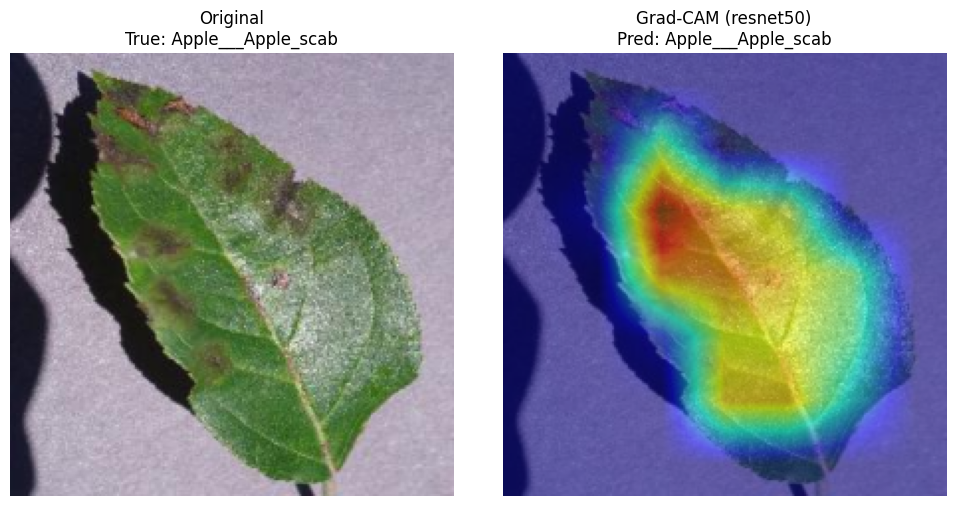

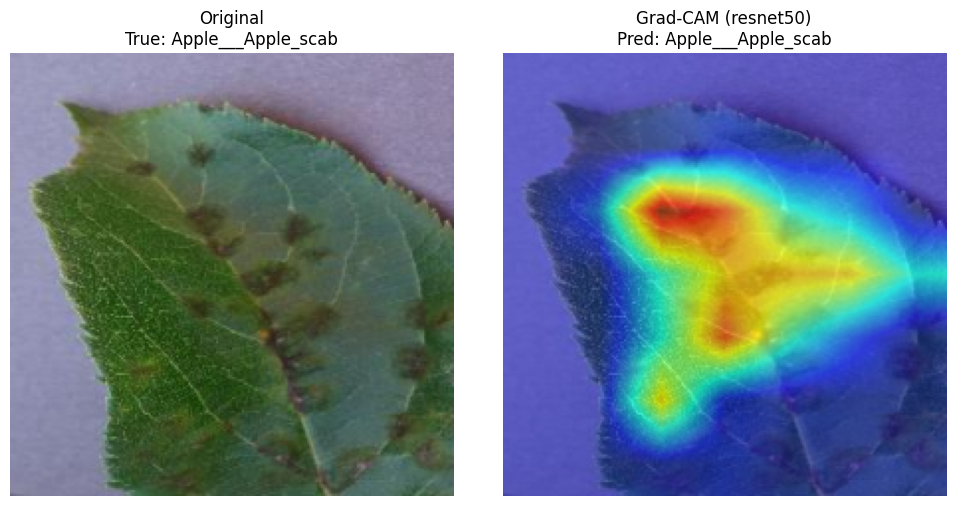

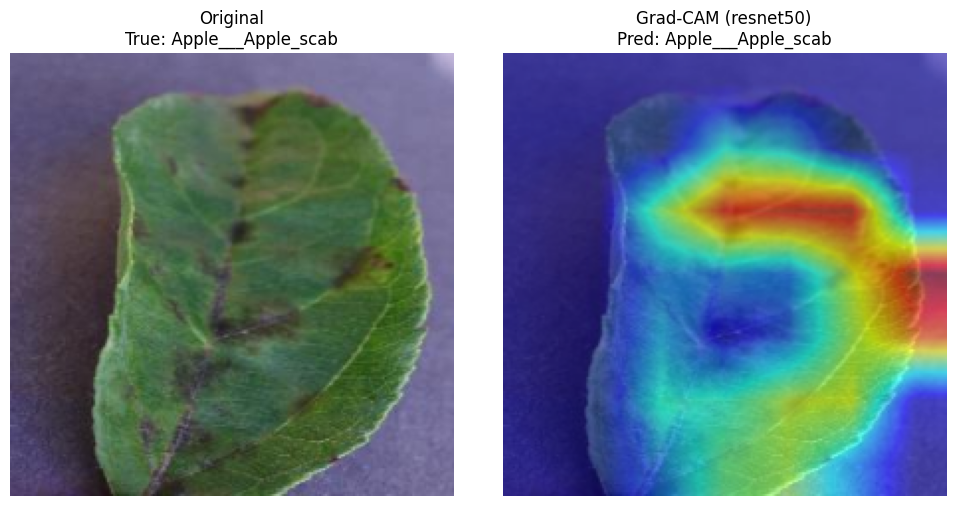

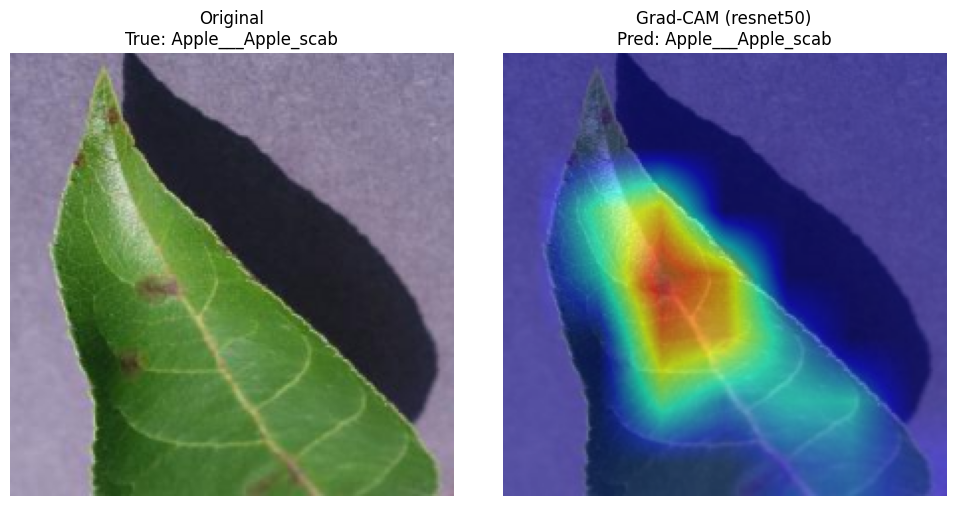

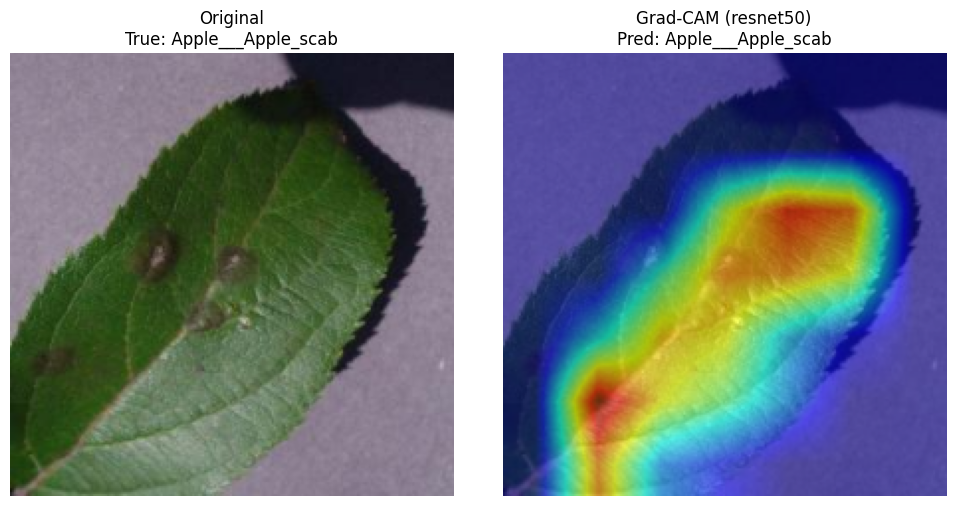

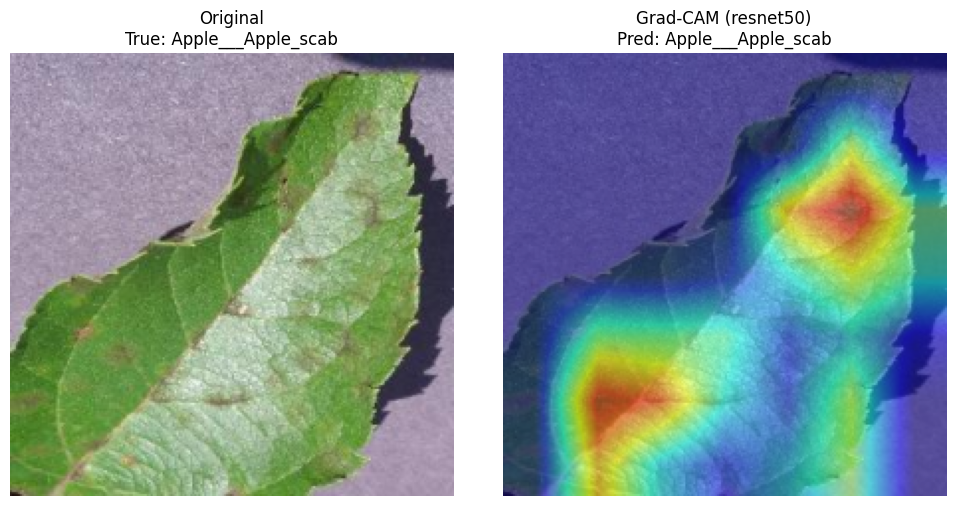

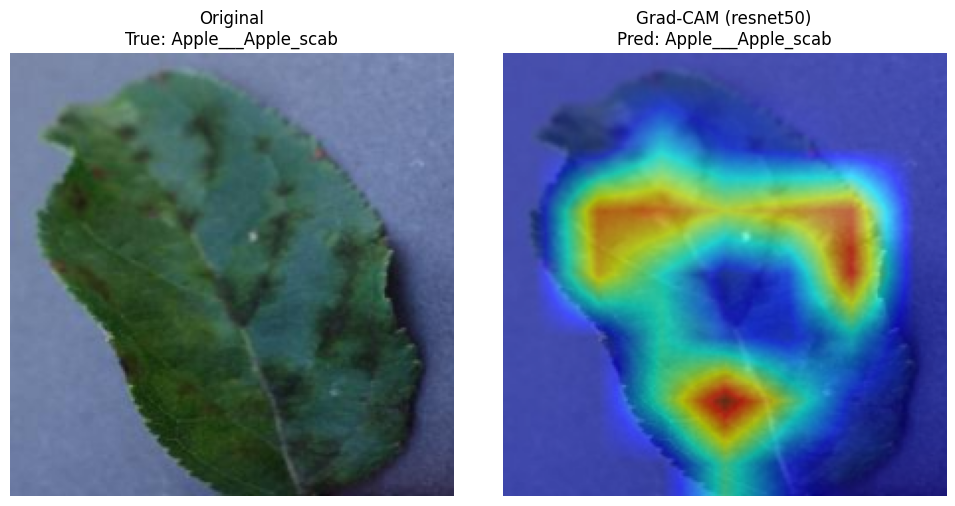

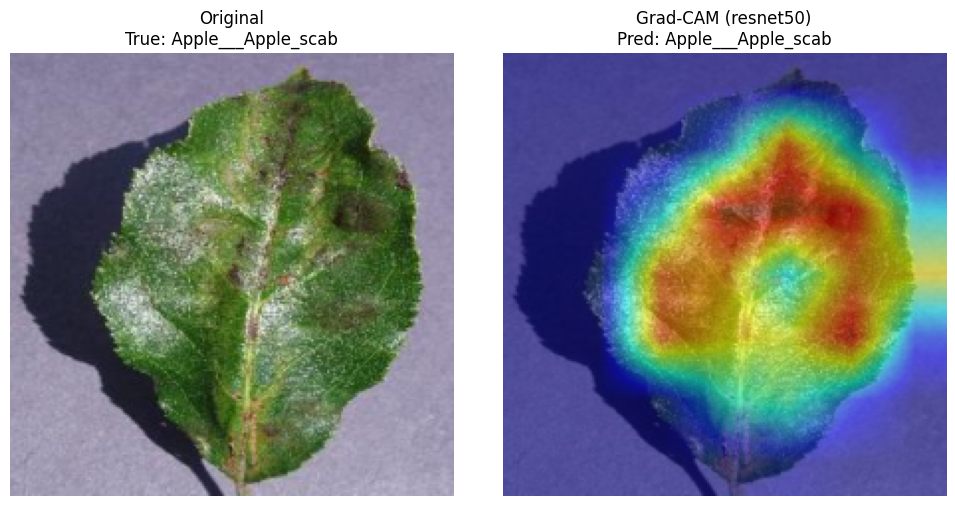

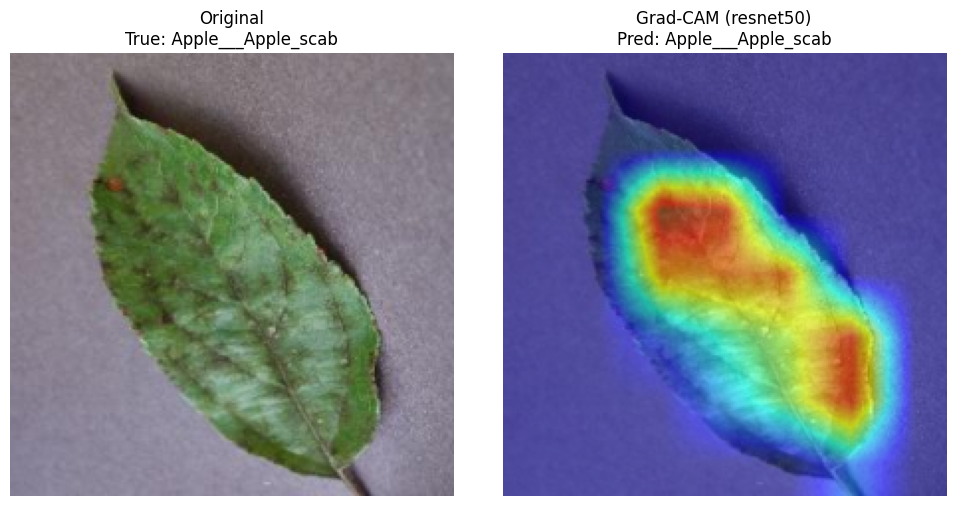

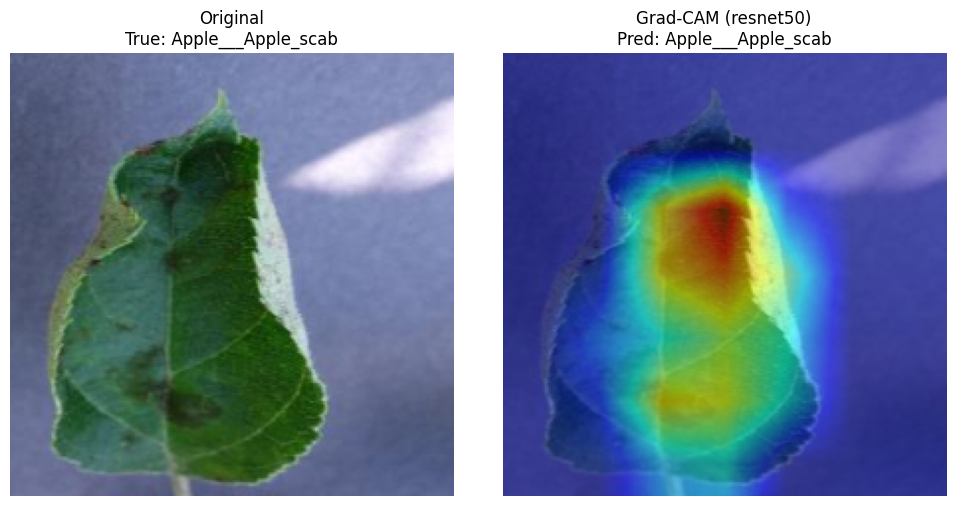

In [18]:
# === Grad-CAM for 10 test images (VGG16 / ResNet50 / MobileNetV2) ===
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Choose which trained model to visualize:
# options: "vgg16", "resnet50", "mobilenet_v2"
ARCH = "resnet50"  # <-- change as needed

# Resolve model from the dict we built earlier
if "models_loaded" in globals() and ARCH in models_loaded:
    cam_model = models_loaded[ARCH]
else:
    raise RuntimeError(f"Model '{ARCH}' not found in models_loaded. Train/load it first.")

cam_model.eval().to(device)

# Prefer class names from test loader dataset
if "test_loader" in globals() and getattr(test_loader, "dataset", None) is not None:
    class_names = getattr(test_loader.dataset, "classes", None)
else:
    class_names = getattr(train_ds, "classes", None)  # fallback
if class_names is None:
    raise RuntimeError("Could not infer class names from datasets.")

# Detect Normalize(mean,std) in the test transforms (if any), so we can unnormalize for display
def detect_normalize(ds):
    t = getattr(ds, "transform", None)
    if t is None: return None
    lst = getattr(t, "transforms", None)
    if lst is None: return None
    for tr in lst:
        if tr.__class__.__name__ == "Normalize" and hasattr(tr, "mean") and hasattr(tr, "std"):
            mean = np.array(tr.mean, dtype=np.float32)
            std  = np.array(tr.std,  dtype=np.float32)
            return (mean, std)
    return None

norm = detect_normalize(test_ds)

# Target layer selector per architecture
def get_target_layers(m: nn.Module, arch: str):
    arch = arch.lower()
    if arch == "resnet50":
        return [m.layer4[-1]]           # last bottleneck block
    elif arch == "vgg16":
        return [m.features[28]]         # last conv layer (features[28] is Conv2d)
    elif arch == "mobilenet_v2":
        return [m.features[-1]]         # last inverted residual block
    else:
        raise ValueError(f"Unknown arch for Grad-CAM: {arch}")

target_layers = get_target_layers(cam_model, ARCH)
cam = GradCAM(model=cam_model, target_layers=target_layers)

# Choose 10 indices (first 10 deterministically; change to random.sample if you prefer randomness)
num_to_show = min(10, len(test_ds))
indices = list(range(num_to_show))

for idx in indices:
    # Fetch sample
    sample_image, label = test_ds[idx]              # sample_image: [C,H,W]
    sample_image = sample_image.unsqueeze(0).to(device)  # [1,C,H,W]

    # Forward to get predicted class (keep grads for CAM)
    outputs = cam_model(sample_image)
    # For our 3 archs, outputs is a tensor
    logits = outputs
    predicted_class = int(logits.argmax(dim=1).item())

    # Build displayable RGB image in [0,1]
    img_chw = sample_image[0].detach().cpu().permute(1, 2, 0).numpy()
    if norm is not None:
        mean, std = norm
        original_image_np = (img_chw * std + mean).clip(0, 1)
    else:
        original_image_np = np.clip(img_chw, 0.0, 1.0)

    # Generate Grad-CAM heatmap
    targets = [ClassifierOutputTarget(predicted_class)]
    grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]  # HxW

    # Overlay
    result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

    # Labels
    pred_name = class_names[predicted_class]
    true_name = class_names[int(label)]

    # Plot for this image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.title(f"Original\nTrue: {true_name}"); plt.imshow(original_image_np); plt.axis('off')
    plt.subplot(1, 2, 2); plt.title(f"Grad-CAM ({ARCH})\nPred: {pred_name}"); plt.imshow(result); plt.axis('off')
    plt.tight_layout()
    plt.show()
